## Aulas 10 e 11 - Reconciliação de Dados
#### Aluno: Vitor Barbosa
#### Teoria: Multiplicadores de Lagrange
Seja uma função $f = f(x,y,z)$ sujeita à restrição $g = g(x,y,z) = k,  k \in \mathbb{R}$
Definimos a Lagrangiana ou função auxiliar $J(x,y,z,\lambda) = f- \lambda g$. 

Desejamos encontrar pontos estacionários da Langrangiana (máximos ou mínimos), o que ocorre quando o gradiente desaparece:
$$\nabla (f-\lambda g) = 0 \iff \nabla f =\lambda\nabla g$$

Interpretação: O gradiente de uma isosuperfície (uma função da forma $h(x,y,z) = k$) representa seu vetor normal, e para que $f$ e $g$ se toquem (sejam tangentes), seus vetores normais precisam ser paralelos, ou seja, isso garante que a restrição será satisfeita.

No nosso caso, $f$ é uma função custo comumente encontrada no problema dos Mínimos Quadrados Ponderados $\textit{(Weighted Least Squares)}$:
$$f(x_i,\hat x_i) = \sum_{i = 1}^N \frac{(x_i-\hat x_i)^2}{\sigma_i^2}$$
Aqui, $\hat x_i$ são os valores reconciliados que desejamos obter e $\sigma_i^2$ são as variâncias das medições.

A restrição $g$ é a Equação da Continuidade para o fluxo incompressível (Balanço de Massa).

Passando para forma matricial, temos:
$$f(\hat X) = (X-\hat X)^TV^{-1}(X-\hat X)$$
$V$ é a matrix de covariância. Para variáveis independentes, ela é uma matriz diagonal com as variâncias das medidas na diagonal principal. $X$ é o vetor com as medidas da planta.
A restrição é o balanço de massas reescrito na forma matricial, com a Matriz de Incidência $A$. Para $m$ restrições (nós) e $n$ variáveis (sensores), temos $m$ linhas e $n$ colunas.
$$g(\hat X) = A\hat X = 0$$
A função auxiliar será:
$$J(\hat X, \lambda) = (X-\hat X)^TV^{-1}(X-\hat X) - 2\lambda^TA\hat X$$
Note que há um $2\lambda^T$ na equação em vez de $\lambda^T$. Creio que isso foi feito para simplificar 
$$\frac{\partial (Y^TBY)}{\partial Y} = 2BY$$Uma vez que $\lambda_i$ é um multiplicador arbitrário, não há problema nisso.

Após as devidas manipulações, temos:
$$\hat X = X - VA^T(AVA^T)^{-1}AX$$

Vista a teoria, vamos implementar o código.



In [1]:
#Exercício 2
#Reconciliando o sistema com 2 nós proposto nos slides do professor
from numpy import zeros, transpose
from numpy.linalg import inv,qr
X = [161,79,80,20,63]
V = zeros((5,5))
V[0,0] = 0.05*X[0]
V[1,1] = 0.01*X[1]
V[2,2] = 0.01*X[2]
V[3,3] = 0.10*X[3]
V[4,4] = 0.05*X[4]
#Multiplicação elemento-a-elemento para transformar desvio padrão em variância
V = V*V;
#X1-X2-X3 = X3-X4-X5 = 0
A = [[1,-1,-1,0,0],[0,0,1,-1,-1]]
Xhat = X-V@transpose(A)@inv(A@V@transpose(A))@A@X
Xhat

array([159.16680979,  79.01765509,  80.14915469,  19.18093868,
        60.96821601])

Sensor  0 - mu= 999.98 sigma= 10.13  Incert=0.14  Bias=-0.02
Sensor  1 - mu= 200.06 sigma=  2.05  Incert=0.06  Bias= 0.06
Sensor  2 - mu= 201.67 sigma=  4.19  Incert=0.09  Bias=-0.33
Sensor  3 - mu= 198.30 sigma=  6.06  Incert=0.11  Bias= 0.30
Sensor  4 - mu= 195.37 sigma=  7.65  Incert=0.12  Bias= 0.37
Sensor  5 - mu= 205.35 sigma= 10.61  Incert=0.15  Bias= 0.35
Sensor  6 - mu= 203.10 sigma= 12.06  Incert=0.16  Bias= 0.10
Sensor  7 - mu= 203.81 sigma= 12.59  Incert=0.16  Bias=-0.19
Sensor  8 - mu= 200.56 sigma= 10.11  Incert=0.14  Bias=-0.44
Sensor  9 - mu= 191.77 sigma=  7.27  Incert=0.12  Bias=-0.23
Sensor 10 - mu= 208.95 sigma=  2.05  Incert=0.06  Bias=-0.05
Sensor 11 - mu= 399.74 sigma=  8.41  Incert=0.13  Bias=-0.26
Sensor 12 - mu= 399.23 sigma= 28.17  Incert=0.24  Bias= 0.23
Sensor 13 - mu= 202.65 sigma=  7.94  Incert=0.13  Bias=-0.35
Sensor 14 - mu= 210.14 sigma= 10.36  Incert=0.14  Bias= 0.14
Sensor 15 - mu= 404.49 sigma=  8.00  Incert=0.13  Bias=-0.51
Sensor 16 - mu= 402.15 s

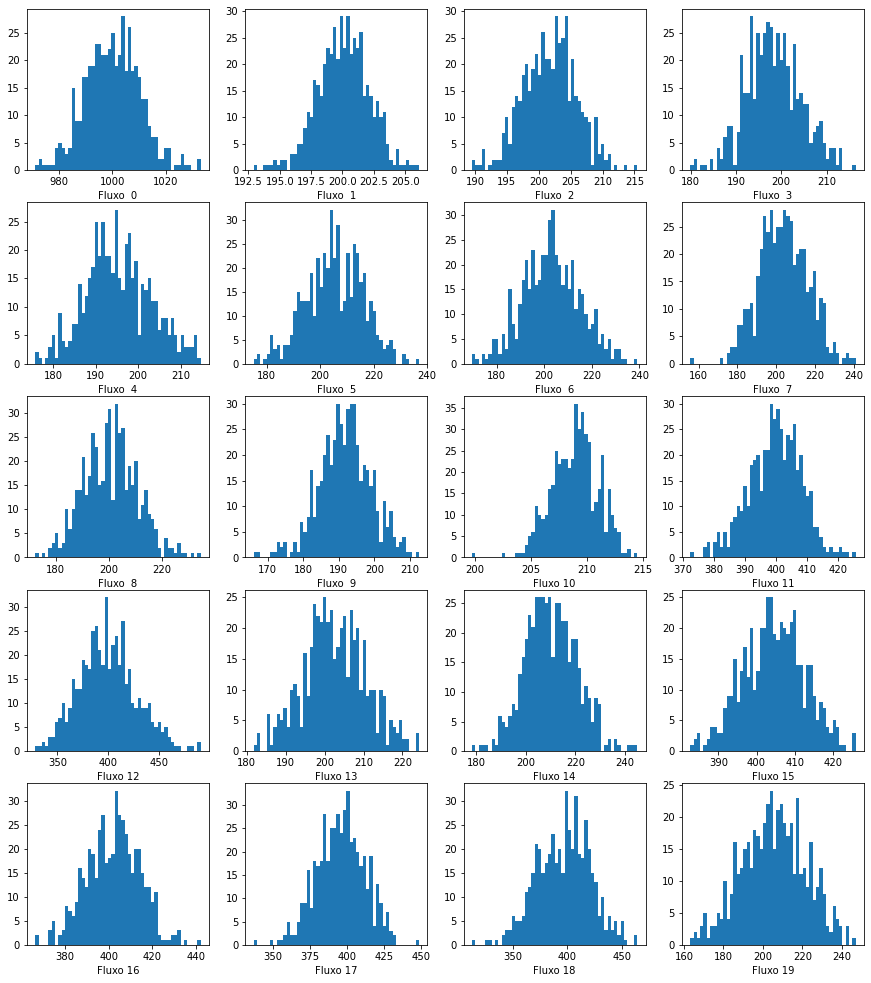

In [2]:
#Exercício 3 - Sistema com 15 nós
from numpy import zeros, transpose,linspace, ones
from numpy.linalg import inv,qr
from random import gauss
from matplotlib import pyplot as plt

#Só pra deixar os gráficos maiores
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

#Mapa do sistema com 15 nós
#a) Todos nós mensuráveis
''' Mapa do sistema. Cada "o" é um nó, cada "f" é um fluxo
f0-o0-f1-o1-f6-o2-f11-o3-f15-o4-f16
   |-f2-o5-f7--/
   |-f3-o6-f8----o7-f12-o8-f17-o9-f18
   |-f4-o10-f9---/
   \-f5-o11-f10-o12-f13-o13-f14-o14-f19
'''
#Médias dos fluxos em m^3/s
f = zeros(20)
s = zeros(20)
f[0] = 1000
f[1] = 200; f[2] = 202; f[3] = 198; f[4] = 195; f[5] = 205
f[6] = 203; f[7] = 204; f[8] = 201; f[9] = 192; f[10] = 209
f[11] = 400; f[12] = 399; f[13] = 203; f[14] = 210;f[16] = 403
f[15] = 405; f[17] = 395; f[18] = 397; f[19] = 206
#Desvios padrões normalizados
s[0] = 0.01; s[1] = 0.01; s[2] = 0.02; s[3] = 0.03; s[4] = 0.04; s[5] = 0.05; s[6] = 0.06
s[7] = 0.06; s[8] = 0.05; s[9] = 0.04; s[10] = 0.01; s[11] = 0.02; s[12] = 0.07; s[13] = 0.04; s[14] = 0.05
s[15] = 0.02; s[16] = 0.03; s[17] = 0.04; s[18] = 0.06; s[19] = 0.08
#Pré-alocando memória para 500 medidas
X = zeros((20,500))
for i in range(500):
    for j in range(20):
        X[j,i] = gauss(f[j],s[j]*f[j])
#Plotando a distribuição de valores graficamente
n = linspace(0,500,500)
plt.subplots_adjust(top=1.4,bottom=0.1)
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.hist(X[i,:],bins=50)
    plt.xlabel("Fluxo %2d"%(i))
    #plt.plot(n,X[i,:]) # plota valores diretamente
    
# Calculando valores das medidas
#Média
mu = zeros(20)
#Desvio padrão = Precisão
sigma = zeros(20) 
#Bias
bias = zeros(20)


for i in range(500): 
    for j in range(20): mu[j] = mu[j]+X[j,i]
mu = mu/500
for i in range(500): 
    for j in range(20): sigma[j] = sigma[j] + (X[j,i]- mu[j])**2
sigma = (sigma/500)**0.5
bias = mu-f

#Incerteza = erro padrão = sigma/sqrt(N)
incert = (sigma/500)**0.5

for i in range(20):
    print("Sensor %2d - mu=%7.2f sigma=%6.2f  Incert=%2.2f  Bias=%5.2f"%(i,mu[i],sigma[i],incert[i],bias[i]))
    #print("Sensor %2d - \u03BC=%7.2f \u03c3=%6.2f  Incert=%2.2f  Bias=%5.2f"%(i,mu[i],sigma[i],incert[i],bias[i]))


In [30]:
#Reconciliação de Dados
from numpy import diag, append
# As matrizes:
#V é matriz de covariancia diagonal, quadrada, com a dimensão do número de sensores
V = diag(sigma*sigma)
# A matriz das restrições vamos tirar do mapa:
''' Mapa do sistema. Cada "o" é um nó, cada "f" é um fluxo
f0-o0-f1-o1-f6-o2-f11-o3-f15-o4-f16
   |-f2-o5-f7--/
   |-f3-o6-f8----o7-f12-o8-f17-o9-f18
   |-f4-o10-f9---/
   \-f5-o11-f10-o12-f13-o13-f14-o14-f19
'''
#Temos A com 15 linhas(restrições) e 20 colunas(variáveis)
#A pode ser obtida diretamente analisando os balanços de massa nos nós
# Vamos percorrer os nós linha a linha, da esquerda para a direita
nRest = 15;
nFlux = 20;
A = zeros((nRest,nFlux))
#Rest 0
A[0,0] = 1;A[0,1:6] = -1 
#Rest 1
A[1,1] = 1;A[1,6] = -1
#Rest 2
A[2,6] = 1;A[2,7]=1;A[2,11] = -1
#Demais restrições
A[3,11]=1;A[3,15]=-1
A[4,15]=1;A[4,16]=-1
A[5,2]=1;A[5,7]=-1
A[6,3]=1;A[6,8]=-1
A[7,8]=1;A[7,9]=1;A[7,12]=-1
A[8,12]=1;A[8,17]=-1
A[9,17]=1;A[9,18]=-1
A[10,4]=1;A[10,9]=-1
A[11,5]=1;A[11,10]=-1
A[12,10]=1;A[12,13]=-1
A[13,13]=1;A[13,14]=-1
A[14,14]=1;A[14,19]=-1

X1 = mu

# A matriz de dados reconciliados
Xhat = X1-V@transpose(A)@inv(A@V@transpose(A))@A@X1


print("\nMatrizes Geradas------------------------------------------------\n")
print("A matriz de covariância V:\n")
print(V)
print("\nMatriz de medidas X1:\n")
print(X1)
print("\nA Matriz de restrições A:\n")
print(A)
print("\n-----------------------------------------------------------------\n")

print("\nOs fluxos reconciliados:\n")
print(Xhat)


Matrizes Geradas------------------------------------------------

A matriz de covariância V:

[[102.60790425   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           4.19985415   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          17.57493865   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          36.77545451   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.       

In [14]:
# Parte 2 - Excluir 5 fluxos
# Os fluxos excluídos: 19,18,17,16,15
# Vamos remover os fluxos não mensuráveis
fexcl = [15,16,17,18,19]
fmens = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
nExcl = len(fexcl);
nMens = len(fmens);
#Fluxos medidos
Ay = zeros((nRest,nMens))
#Fluxos só observados (não medidos)
Az = zeros((nRest,nExcl))

i = 0; k = 0
for j in range(nFlux):
    if(j not in fexcl): #Se o fluxo não deve ser excluído
        Ay[:,i] = A[:,j] #Copia a restrição da coluna do fluxo da matriz A para a matriz Ay
        i=i+1
    else:
        Az[:,k] = A[:,j]#Copia a restrição da coluna do fluxo para a matriz Az
        k=k+1  


O problema de otimização agora estará sujeito a 
$$A_y\hat Y + A_z\hat Z = 0$$
Sendo $A_y$ a matriz de restrições com os fluxos mensuráveis e $A_z$ a matriz com os fluxos não mensuráveis, mas observáveis.

Precisamos eliminar $A_z$, o que faremos usando a matriz de projeção $P$ tal que $PA_z = 0.$

A matriz $PA_y$ tem a forma de um vetor que só possui elementos não nulos para os fluxos redundantes correspondentes.

Definiremos a matriz 
$$ A'  \quad |\quad  A_i'=(PA_y)_i \,\, \forall \,\, (PA_y)_i\neq 0 $$
Temos então:
$$\hat Y = Y - V(A')^T[(A')V(A')^T]^{-1}A'Y$$


In [29]:
#Vamos encontrar a matriz de projeção P por fatorização QR:
q,r = qr(Az,mode='complete')

P = q[:,-1] # ultima coluna de q é a matriz de projeção

#O vetor PAy indica os fluxos não redundantes
# Se um elemento é nulo, quer dizer que o fluxo não é redundante e não pode ser reconciliado
#PAy tem o comprimento igual ao numero de fluxos mensuráveis
print("A matriz PAy indica os fluxos redundantes: \n")
PAy = P@Ay
print(PAy)
print("\n")

nRedundant=0

for i in range(nMens):
    if(PAy[i]!=0): #Se o fluxo é redundante, pode-se reconciliá-lo, outros fluxos podem ajudar
        nRedundant+=1
        print("A medida %2d é redundante" %i)
    else:
        print("A medida %2d não é redundante" %i)


#Alocando memória
#Matriz de variância
V=zeros((nRedundant,nRedundant))
#Matriz de medidas dos fluxos redundantes
Y=zeros((nRedundant,1))
#Matriz de restrições, é a matriz A'
A_=zeros((1,nRedundant))
#Matriz com todos os fluxos mensuráveis, após a reconciliação
Yfull=zeros((nMens,1))

n = 0
for i in range(nMens):
    if(PAy[i]!=0):#Se o fluxo é redundante
        Y[n,:] = mu[fmens[i]]#Só incluir as medidas redundantes
        V[n,n] = sigma[fmens[i]]*sigma[fmens[i]]
        A_[:,n] = PAy[i] #Construindo a matriz A' segundo sua definição
        n += 1
    else:
        #Se o fluxo não é redundante, já copiamos ele direto pra matriz final
        #Pois ele não será reconciliado
        Yfull[i,:] = mu[fmens[i]] 

# Reconciliando
Yhat = Y-V@transpose(A_)@inv(A_@V@transpose(A_))@A_@Y

n = 0
for i in range(nMens):
    if(Yfull[i]==0): 
        Yfull[i] = Yhat[n] # Colocando os fluxos reconciliados na matriz final
        n = n+1
#Finalmente, reconciliamos of fluxos observáveis, mas não medidos (os excluídos)
Zhat = -inv(transpose(Az)@Az)@transpose(Az)@(Ay@Yfull)

print("\nMatrizes dos Fluxos Redundantes----------------------------------\n")
print("A matriz de covariância V:\n")
print(V)
print("\nMatriz de medidas Y:\n")
print(Y)
print("\nA Matriz de restrições A':\n")
print(A_)
print("\n-----------------------------------------------------------------\n")

print("\nOs fluxos mensuráveis:\n")
for n in range(nMens): print("Fluxo %2d -> %3.3f" %(fmens[n],Yfull[n]))

print("\nOs fluxos observáveis, mas excluídos (não mensuráveis):\n")
for n in range(nExcl): print("Fluxo %2d -> %3.3f" %(fexcl[n],Zhat[n]))

A matriz PAy indica os fluxos redundantes: 

[-7.07106781e-01  1.41421356e+00  7.07106781e-01  7.07106781e-01
  7.07106781e-01  7.07106781e-01 -7.07106781e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.55111512e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


A medida  0 é redundante
A medida  1 é redundante
A medida  2 é redundante
A medida  3 é redundante
A medida  4 é redundante
A medida  5 é redundante
A medida  6 é redundante
A medida  7 não é redundante
A medida  8 não é redundante
A medida  9 não é redundante
A medida 10 não é redundante
A medida 11 é redundante
A medida 12 não é redundante
A medida 13 não é redundante
A medida 14 não é redundante

Matrizes dos Fluxos Redundantes----------------------------------

A matriz de covariância V:

[[102.60790425   0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.           4.19985415   0.           0.           0.
    0.           0.           0.        ]
 [  0. 

Fontes:

https://en.wikipedia.org/wiki/Lagrange_multiplier
https://tutorial.math.lamar.edu/classes/calciii/lagrangemultipliers.aspx
https://en.wikipedia.org/wiki/Continuity_equation
https://en.wikipedia.org/wiki/Weighted_least_squares
http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf
https://www2.southeastern.edu/Academics/Faculty/rallain/plab194/error.html
